In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from scipy.io import loadmat

In [2]:
class_dict = {
    'raise_arm': 0,
    'run': 1,
    'bow': 2,
    'walk': 3,
}

In [7]:
win_len=200

def generate_dataset(path, step=100, win_len=win_len, dirty = False):

    folders = [p for p in os.listdir(path) if p != ".DS_Store"]

    # print("detect {} class:{}".format(len(folders), folders))
    X = []
    Y = []
    num_classes= len(folders)

    for folder in folders:
        folder_path = os.path.join(path, folder)
        filenames = [f for f in os.listdir(folder_path) if f.endswith(".mat")]
        for filename in filenames:
            # load data
            file_path = os.path.join(folder_path, filename)
            print(file_path)
            # print(file_path)
            csi_data= loadmat(file_path)
            csi_array = csi_data['csi']
            csi_array = np.absolute(csi_array)

            # screen the data with a window
            index = 1000
            while index + win_len <= csi_array.shape[0]:
                cur_seg = csi_array[index : index + win_len]
                index += step
                if np.any(np.isnan(cur_seg)):
                    col_mean = np.nanmean(cur_seg, axis=0)
                    # print(np.shape(cur_seg), np.shape(col_mean))
                    inds = np.where(np.isnan(cur_seg))
                    # print(inds)
                    cur_seg[inds] = np.take(col_mean, inds[1])
                    continue
                
                # determine the activity by using moving variance.
                var = np.var(np.abs(cur_seg[:step, 1])) 
                # print('var:', var)
                high_limit = 2.5
                if dirty:
                    high_limit = 100 

                if var > 0.6 and var < high_limit:
                    X.append(cur_seg)
                    Y.append(class_dict[folder]);
            break

    X = np.array(X)
    Y = np.array(Y)
    assert not np.any(np.isnan(X))
    print('0', (Y == 0).sum())
    print('1', (Y == 1).sum())
    print('2', (Y == 2).sum())
    print('3', (Y == 3).sum())
    Y = tf.keras.utils.to_categorical(Y, num_classes=num_classes)
    return X, Y, num_classes

In [8]:
X_train, Y_train, num_classes = generate_dataset('./usrp_dataset2/training/')
X_test, Y_test, num_classes = generate_dataset('./usrp_dataset2/testing/')
X_dirty, Y_dirty, num_classes = generate_dataset('./usrp_dataset2/dirty/', dirty = True)


./usrp_dataset2/training/walk/1.mat
(10320, 52)
./usrp_dataset2/training/bow/1.mat
(10320, 52)
./usrp_dataset2/training/run/1.mat
(10560, 52)
./usrp_dataset2/training/raise_arm/1.mat
(10080, 52)
0 0
1 0
2 0
3 0
./usrp_dataset2/testing/walk/1.mat
(4634, 52)
./usrp_dataset2/testing/bow/1.mat
(4881, 52)
./usrp_dataset2/testing/run/1.mat
(4441, 52)
./usrp_dataset2/testing/raise_arm/1.mat
(5075, 52)
0 0
1 0
2 0
3 0
./usrp_dataset2/dirty/walk/1.mat
(5207, 52)
./usrp_dataset2/dirty/bow/1.mat
(4720, 52)
./usrp_dataset2/dirty/run/1.mat
(4440, 52)
./usrp_dataset2/dirty/raise_arm/1.mat
(5246, 52)
0 0
1 0
2 0
3 0


In [6]:
print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)
print(np.shape(X), np.shape(Y))
print(X_train.dtype)


(0,) (0, 4)
(0,) (0, 4)
(0,) (0, 4)
float64


In [7]:
def train_valid_split(X, Y, train_portion=0.7, seed=379):
    np.random.seed(seed=seed)
    num_samples = np.shape(X)[0]
    index = np.random.permutation([i for i in range(num_samples)])
    split_len = int(train_portion * num_samples)
    X_train = X[index[:split_len], ...]
    Y_train = Y[index[:split_len], ...]
    X_valid = X[index[split_len:], ...]
    Y_valid = Y[index[split_len:], ...]
    return (X_train, Y_train), (X_valid, Y_valid)

In [8]:
# normalization
print(np.shape(X))
mean = np.mean(X, axis=0)
print(np.shape(mean))
std = np.std(X, axis=0)
print(np.shape(std))

norm_X = (X - mean)/std
norm_X_dirty= (X_dirty - mean)/std

print(norm_X[0])

(327, 200, 52)
(200, 52)
(200, 52)
[[-0.01428883+0.82720158j -0.10195965+0.84167849j  0.18735255-0.60556714j
  ...  0.87646093-0.67394502j  0.87117238-0.517397j
   1.03789715-0.58433755j]
 [-0.08649888+1.2293587j  -0.12065654+1.20706078j  0.27857554-0.9974342j
  ...  0.26662094-1.13482561j  0.41156169-1.57581898j
   0.42700015-1.1501421j ]
 [-0.30508269+1.43207801j -0.17385028+1.51475724j  0.2025073 -1.36975474j
  ... -0.35281113-1.11332364j -0.23240813-1.33052901j
  -0.24823282-1.43548407j]
 ...
 [-0.04060333-1.24408816j -0.32136156-1.21321037j  0.04829931+1.21452618j
  ...  0.49253577+0.99677068j  0.23253416+0.83358609j
   0.35893544+1.1225973j ]
 [ 0.37601415-0.49201954j  0.59991472-0.36310091j -0.45912733+0.49819518j
  ...  0.08938717+0.92799074j  0.22517779+0.38944845j
   0.31249264+0.66984125j]
 [ 0.39133951-0.443884j    0.43906279-0.59319722j -0.61579941+0.54365192j
  ... -0.4175148 -0.07616784j  0.19007765+0.12468781j
  -0.03517218+0.04521817j]]


In [9]:
(X_train, Y_train), (X_valid, Y_valid) = train_valid_split(norm_X, Y)

print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_valid), np.shape(Y_valid))

(228, 200, 52) (228, 4)
(99, 200, 52) (99, 4)


In [10]:
import csimodel
cfg = csimodel.CSIModelConfig(win_len=win_len, step=200, thrshd=0.6, downsample=1)
model = cfg.build_ourmodel(label=4, n_unit_lstm=200, n_unit_atten=400, feature=52)
model.summary()


2022-07-26 01:32:26.274034: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 01:32:26.302499: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9fbaf3c6f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-26 01:32:26.302527: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 52)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 400)          404800    
_________________________________________________________________
atten_layer (AttenLayer)     (None, 400)               160800    
_________________________________________________________________
dense (Dense)                (None, 4)                 1604      
Total params: 567,204
Trainable params: 567,204
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [12]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=128, epochs=3,
    validation_data=(X_valid, Y_valid),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_atten_our.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
        ])

Train on 228 samples, validate on 99 samples
Epoch 1/3


/Users/wenjinzhang/opt/anaconda3/envs/CSI/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


228/228 [==============================] - ETA: 0s - loss: 1.3274 - accuracy: 0.5395WARNING:tensorflow:From /Users/wenjinzhang/opt/anaconda3/envs/CSI/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
228/228 [==============================] - 2s 7ms/sample - loss: 1.3274 - accuracy: 0.5395 - val_loss: 1.2669 - val_accuracy: 0.7374
Epoch 2/3
228/228 [==============================] - 1s 6ms/sample - loss: 1.2541 - accuracy: 0.7237 - val_loss: 1.1906 - val_accuracy: 0.7475
Epoch 3/3
228/228 [==============================] - 1s 5ms/sample - loss: 1.1824 - accuracy: 0.6886 - val_loss: 1.1187 - val_accuracy: 0.7576


In [13]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

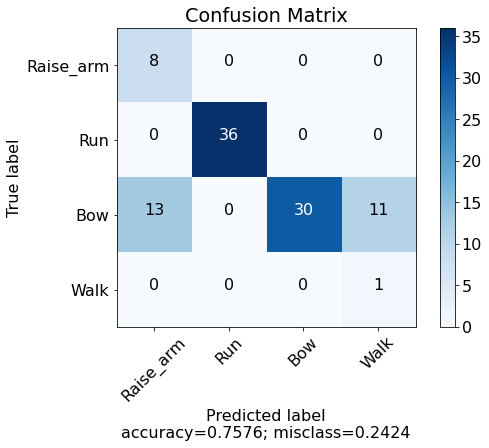

In [14]:
[loss, accuracy] = model.evaluate(X_valid, Y_valid)

Y_valid_predict = model.predict(X_valid)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.argmax(Y_valid_predict, axis=1), np.argmax(Y_valid, axis=1))
plot_confusion_matrix(cm = matrix,
                      target_names = ['Raise_arm', 'Run', 'Bow', 'Walk'],
                      title        = "Confusion Matrix")

In [19]:
print(X_valid.dtype)

complex128


# Generate the Universial Perturbation Through Deepfool

In [15]:

from art.classifiers import KerasClassifier
from art.attacks import TargetedUniversalPerturbation
from art.utils import random_sphere

# build targeted UAP
classifier = KerasClassifier(model=model)
adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.000001,
    attacker_params={'targeted':True, 'eps':0.006},
    max_iter=10,
    eps=5.5,
    norm=2)


# set target label
target = 1
y_train_adv_tar = np.zeros(Y_train.shape)
for i in range(Y_train.shape[0]):
    y_train_adv_tar[i, target] = 1.0

# generate noise
_ = adv_crafter.generate(X_train, y=y_train_adv_tar)



/Users/wenjinzhang/opt/anaconda3/envs/CSI/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
2022-07-26 01:32:40.295881: W tensorflow/c/c_api.cc:326] Operation '{name:'bidirectional/backward_lstm_1/while' id:464 op device:{} def:{{{node bidirectional/backward_lstm_1/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=45, _read_only_resource_inputs=[8, 9, 10], body=bidirectional_backward_lstm_1_while_body_564[], cond=bidirectional_backward_lstm_1_while_cond_563[], output_shapes=[[], [], [], [], [?,200], ..., [], [], [], [], []], parallel_iterations=32](bidirectional/backward_lstm_1/while/loop_counter, bidirectional/backward_lstm_1/while/maximum_iterations, bidirectional/backward_lstm_1/time, bidirectional/backward_lstm_1/Te

TypeError: 'int' object is not subscriptable

In [18]:
print(type(adv_crafter.noise))
# noise = adv_crafter.noise[0,:]

# X_train_adv = X_train + noise
# X_valid_adv = X_valid + noise

<class 'int'>


5/5 [==============================] - 0s 89ms/step - loss: 2.1001 - accuracy: 0.2733


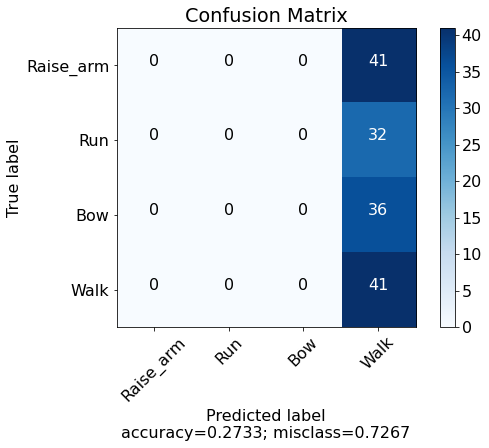

In [ ]:
[loss, accuracy] = model.evaluate(X_dirty, Y_dirty)

Y_dirty_predict = model.predict(X_dirty)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.argmax(Y_dirty, axis=1), np.argmax(Y_dirty_predict, axis=1))

plot_confusion_matrix(cm = matrix,
                      target_names = ['Raise_arm', 'Run', 'Bow', 'Walk'],
                      title        = "Confusion Matrix")

In [ ]:
X_train, Y_train, num_classes = generate_dataset('./usrp_dataset2/training/')

norm_X = (X_train- mean)/std

[loss, accuracy] = model.evaluate(norm_X, Y_train)

./usrp_dataset2/training/walk/1.mat
./usrp_dataset2/training/bow/1.mat
./usrp_dataset2/training/run/1.mat
./usrp_dataset2/training/raise_arm/1.mat
0 51
1 74
2 70
3 46
8/8 [==============================] - 1s 102ms/step - loss: 0.2183 - accuracy: 0.9876


: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
dirty_X, dirty_Y, num_classes = generate_dataset('./our_dataset/data/dirty')
print(len(dirty_Y))

model.evaluate(dirty_X, dirty_Y);

In [ ]:
model.predict(dirty_X)
x = model.predict(dirty_X)
print(np.argmax(x, axis=1))
print(np.argmax(dirty_Y, axis=1))

## Create the adversarial sample

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original CSI resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the input.

In [ ]:
import tensorflow as tf
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_images, input_labels):

  input_image = tf.convert_to_tensor(input_images, dtype=tf.float32)
  input_label = tf.convert_to_tensor(input_labels, dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)

  fgm_grad= gradient / tf.norm(gradient, ord=2)

  return signed_grad, fgm_grad

# Get the original CSI.

In [ ]:
import matplotlib.pyplot as plt
original_csis = X_valid
original_targets = Y_valid

In [ ]:
perturbations1, perturbations2 = create_adversarial_pattern(original_csis, original_targets)

In [ ]:
def accuracy(x_valid, y_valid):
    y_pred = model.predict(x_valid)
    y_predict = np.argmax(y_pred, axis=1)
    y_valid_one = np.argmax(y_valid, axis=1)
    accuracy = round(sum([y_ == y for y_, y in zip(y_predict, y_valid_one)])/len(y_valid_one) * 100,2)
    print("accuracy: {}%".format(accuracy))
    return accuracy

In [ ]:
epss = [];
adv_accuracys = [];
clean_accuracys = [];
for eps in range(0, 11):
    adv_x = original_csis
    adv_x = adv_x + eps * perturbations1
    # compute accuracy
    acc = accuracy(adv_x, original_targets)
    epss.append(eps/10)
    adv_accuracys.append(acc)
    clean_accuracys.append(98.46)
    print("eps: {} ---> adv_acc:{}%".format(eps, acc))

In [ ]:
clean1 = plt.plot(epss, clean_accuracys, marker = 'v', linestyle = 'solid', label='Clean')
adv1 = plt.plot(epss, adv_accuracys, marker = 'o', linestyle = 'solid', label='FGM')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy(%)")
plt.show()